# Speech Processing for ML:Filter banks, MFCC.

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
import tensorflow as tf

# Math
import numpy as np
from scipy.fftpack import fft,dct
from scipy import signal
from scipy.io import wavfile
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline


In [2]:
filename = 'trial.wav'
seconds = 3
sample_rate, samples = wavfile.read(filename)
samples = samples[0:seconds*sample_rate]

In [3]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate,
                                           window='hann', 
                                           nperseg=nperseg,
                                           noverlap=noverlap,
                                           detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

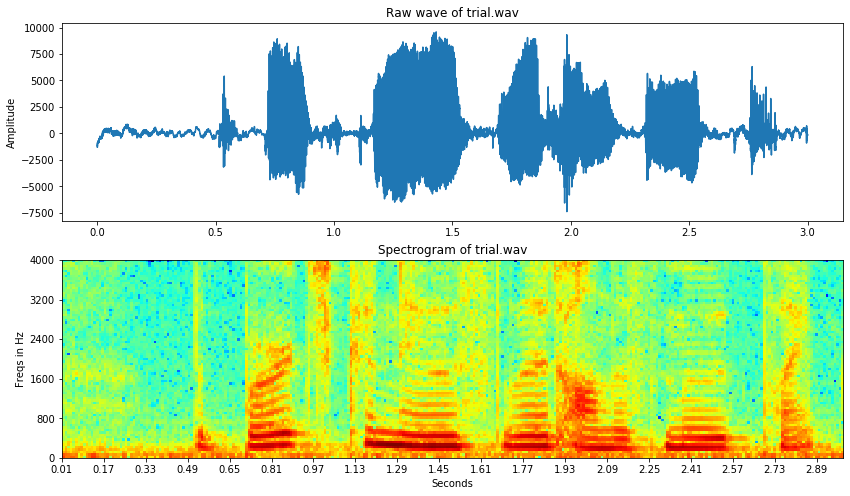

In [4]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples)/sample_rate, seconds*sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, cmap="jet",aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

##  1.pre-emphasize 

$y(t)=x(t)-\alpha x(t-1)$

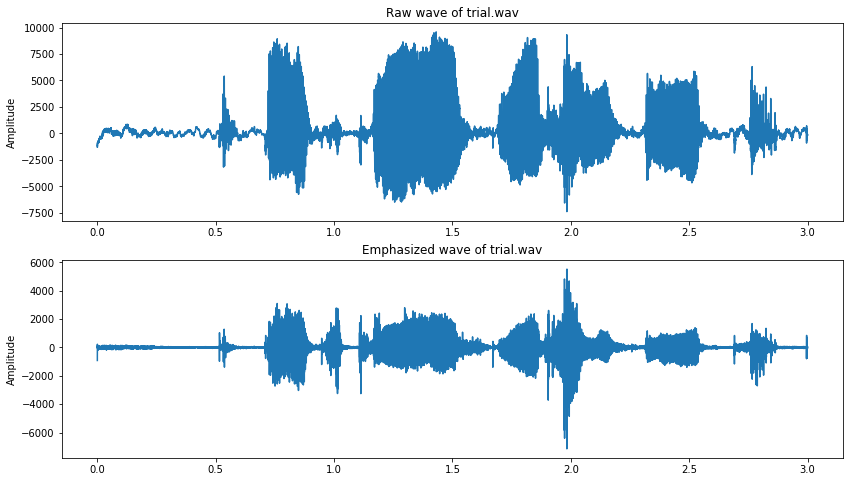

In [5]:
def pre_emphasized(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

emphasized = pre_emphasized(samples)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples)/sample_rate, seconds*sample_rate), samples)
ax1 = fig.add_subplot(212)
ax1.set_title('Emphasized wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples)/sample_rate, seconds*sample_rate), emphasized)


## 2.分帧
预之后需要将信号分帧，因为对整个信号进行傅立叶变换是没有意义的。在这里，假设在短时间内频率的变化不大（平稳），在短时间的帧内以及连接相邻的帧来进行傅立叶变换可以得到整个信号轮廓的良好近似。
一般得，典型帧大小为20～40ms（window_size）, 帧与帧之间重叠为50%(overlap)。

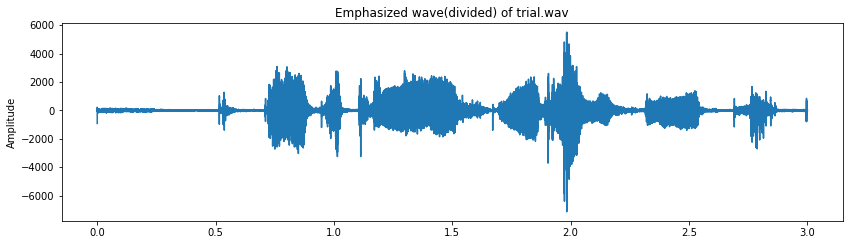

In [6]:
def divide_frame(emphasized_signal, sample_rate, frame_size=20, stride_size=10):
    nperseg, noverlap = int(round(frame_size*sample_rate / 1e3)), int(round(stride_size*sample_rate / 1e3))
    nframe = int(np.ceil(float(np.abs(nperseg-len(emphasized_signal)))/noverlap)) + 1
    pad_signal_length = nframe*noverlap + nperseg - noverlap
    if pad_signal_length - len(emphasized_signal) != 0:
        z = np.zeros((pad_signal_length - len(emphasized_signal)))
        pad_signal = np.append(emphasized_signal, z)
    else:
        pad_signal = emphasized_signal.copy()
    indices = np.tile(np.arange(0, nperseg), (nframe, 1)) + np.tile(np.arange(0, nframe*noverlap, noverlap),(nperseg, 1)).T
    frames = pad_signal[np.mat(indices).astype(np.int32, copy=False)]
    return nperseg, frames, pad_signal

nperseg, divided_frame, pad_signal = divide_frame(emphasized, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Emphasized wave(divided) of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples)/sample_rate, seconds*sample_rate), pad_signal)


## 3. 窗口
将信号切分为帧之后，我们讲一个窗口函数应用到每一帧。Hamming window:
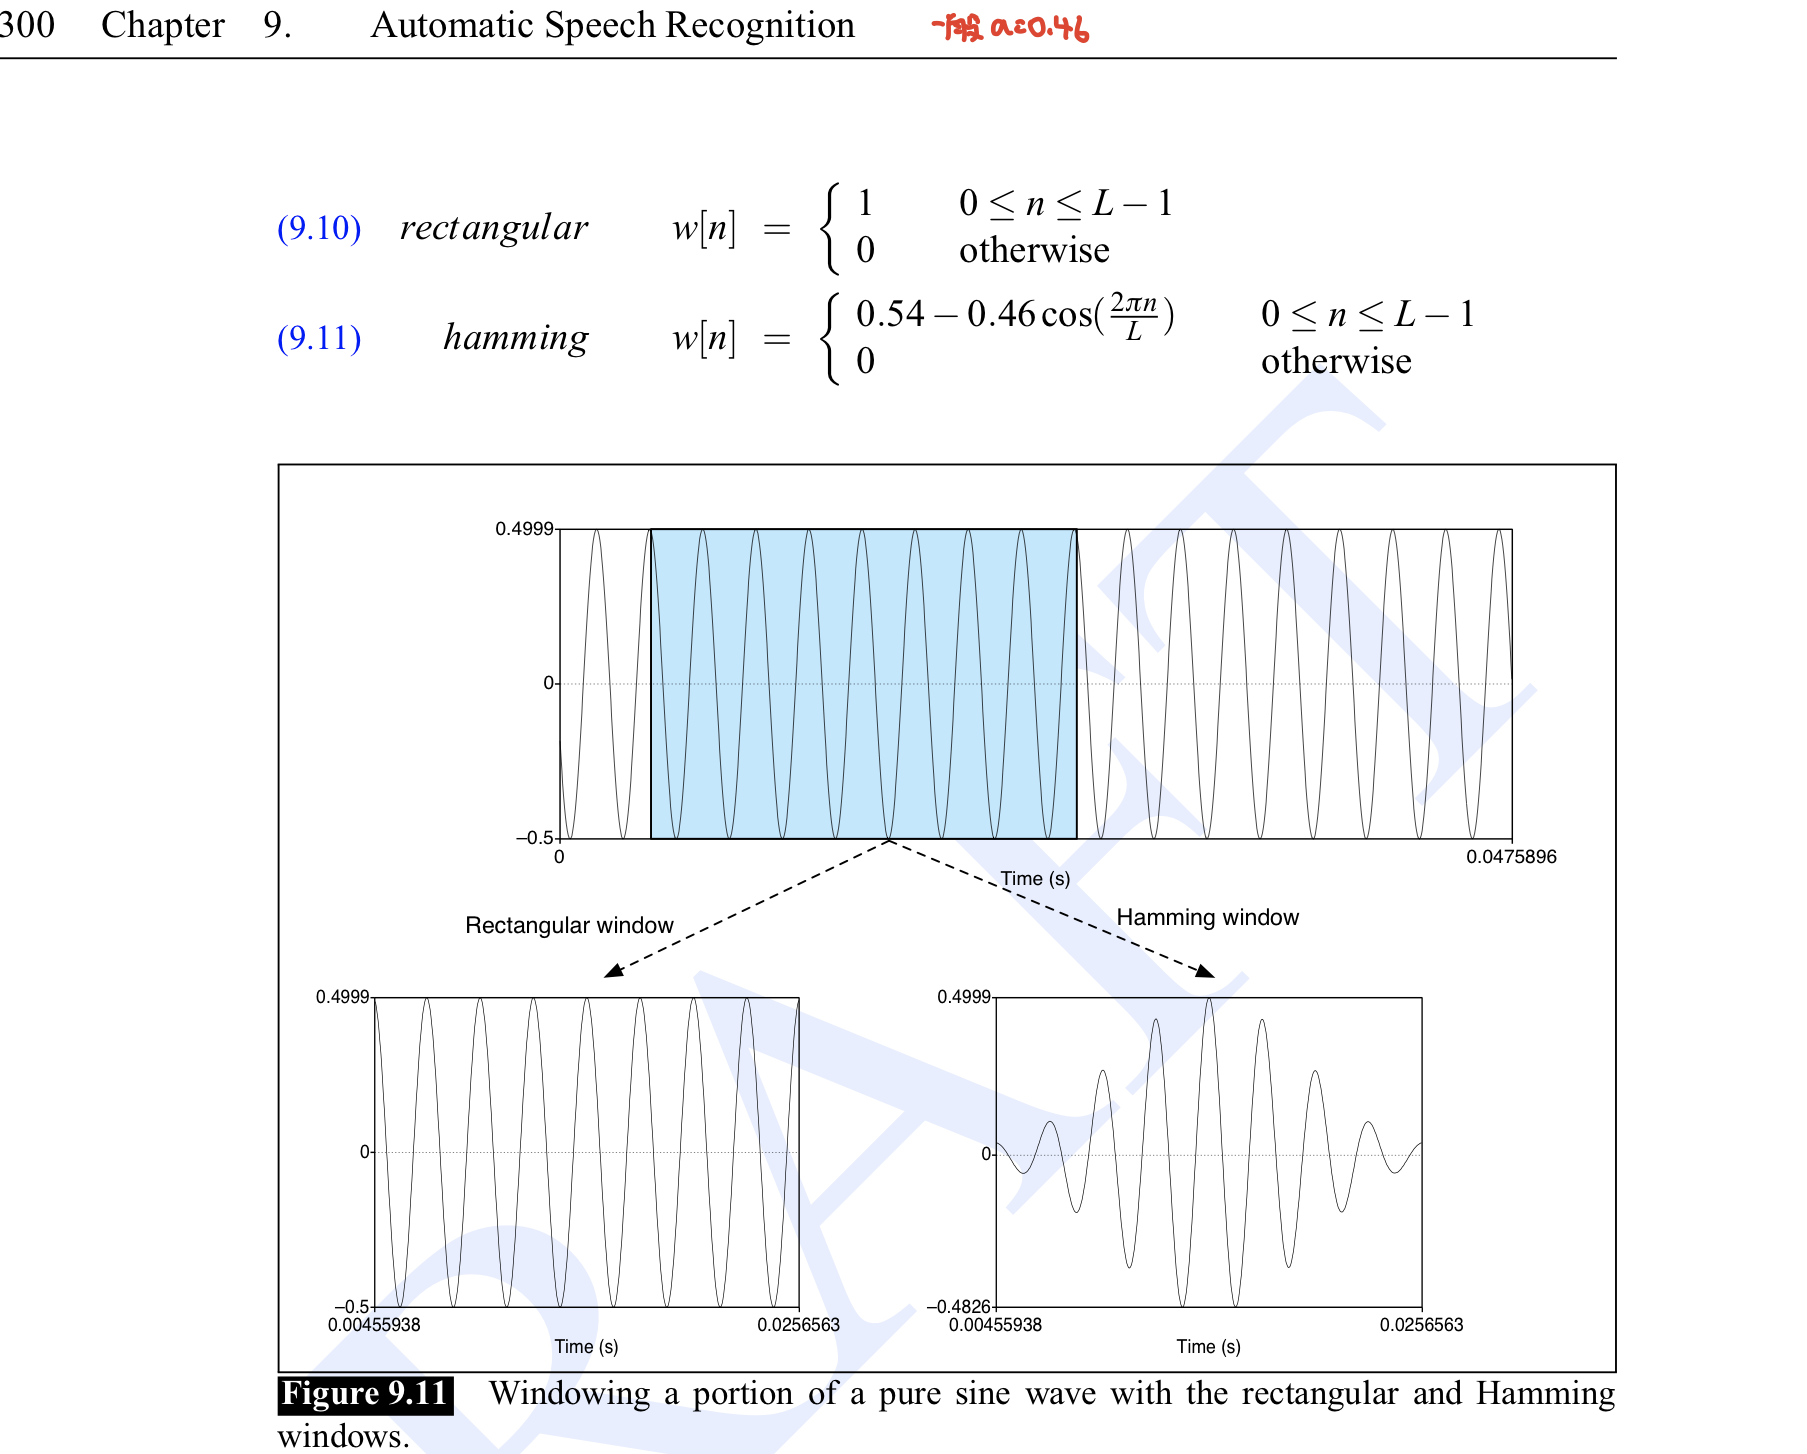


In [7]:
divided_frame *= np.hamming(nperseg)

## 4.傅立叶变换与功率谱

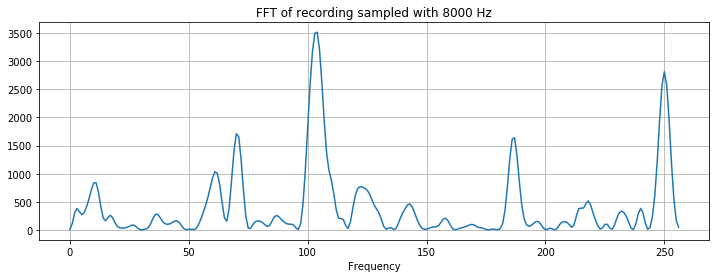

In [8]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(divided_frame, NFFT))
pow_frames = (1.0/NFFT) * (mag_frames ** 2)

plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(pow_frames[1])
plt.xlabel('Frequency')
plt.grid()
plt.show()

## 5.滤波器组
由于人耳对不同频率声音信号有着不同的敏感度，为了模拟人耳的这种特性，采用三角滤波来提取
$$m=2595log_{10}(1+\frac{f}{700})\\
f=700*(10^{m/2595}-1)$$
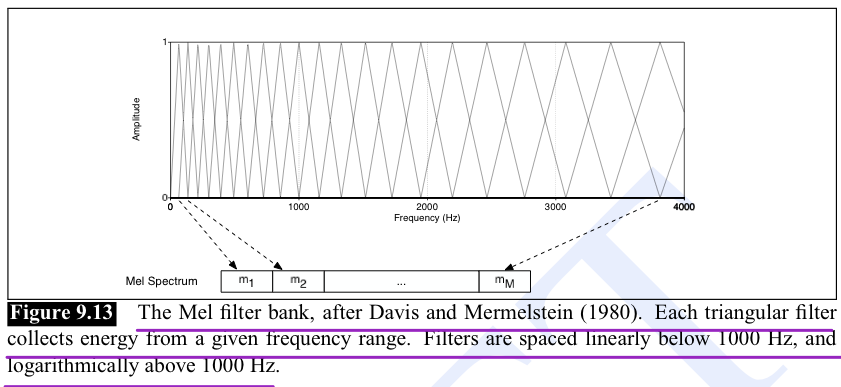
\begin{equation}
H_m(x) = 
\begin{cases}
0 & k < f(m-1)\\
\frac{k-f(m-1)}{f(m)-f(m-1)} & f(m-1) \leq k < f(m) \\
1 & k=f(m) \\
\frac{f(m+1)-k}{f(m+1)-f(m)} & f(m) < k \leq f(m+!) \\
0& k \geq f(m-1) \\
\end{cases}
\end{equation}

In [9]:
def filter_bank(sample_rate, pow_frames, NFFT):
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1+(sample_rate / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt +2)
    hz_points = 700 * (10**(mel_points/2595)-1)
    
    binn = np.floor((NFFT+1) * hz_points / sample_rate)
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1 ))))
    
    for m in range(1, nfilt+1):
        f_m_minus = int(binn[m-1])
        f_m = int(binn[m])
        f_m_plus = int(binn[m+1])
        for k in range(f_m_minus, f_m):
            fbank[m-1,k] = (k - binn[m-1]) / (binn[m] - binn[m-1])
        for k in range(f_m, f_m_plus):
            fbank[m-1,k] = (binn[m+1] - k) / (binn[m+1] - binn[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)
    return filter_banks

filter_bank_signal = filter_bank(sample_rate, pow_frames, NFFT)


Text(0.5, 0, 'Time(s)')

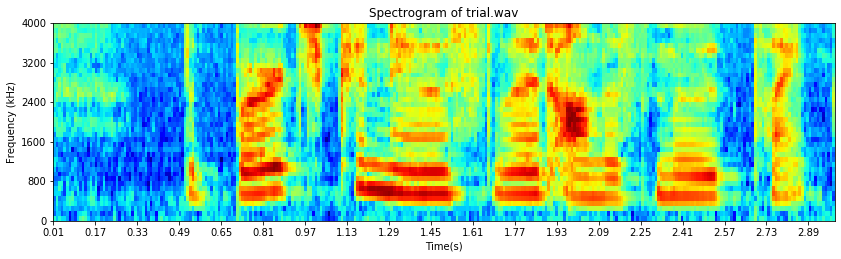

In [10]:
fig = plt.figure(figsize=(14, 8))

ax2 = fig.add_subplot(211)
ax2.imshow(filter_bank_signal.T, cmap="jet",aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequency (kHz)')
ax2.set_xlabel('Time(s)')

## 6.Mel-frequency Cepstral Coefficients(MFCCs)
*如果fliter-bank就是你所要求的特征，那么下面的步骤是可以跳过的。

由于filter-bank计算出来的特征是高度相关的，在部分学习算法中会导致一些问题（因为很多算法假定了它们的输入数据不相关而且这种假定对于模型的
影响比较大）。因此我们需要额外地考虑用DCT(Discrete Cosine Transform)来将filter-bank特征退相关化，来生成一些被压缩过的表示。特别地，在
ASR(Automatic Speech Recognition)中，倒谱系数中的第2-13个系数被保留。其他的系数代表了频谱的快速变换以及其他精细的特征，这些对于ASR
来说是不需要的。

Text(0.5, 0, 'Time(s)')

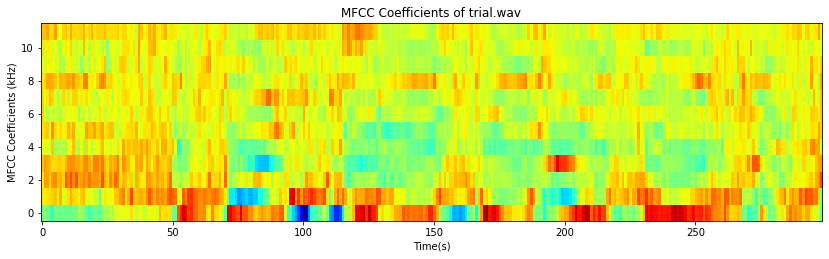

In [11]:
num_ceps = 12
mfcc = dct(filter_bank_signal, type=2, axis=1, norm='ortho')[:,1:(num_ceps+1)]

fig = plt.figure(figsize=(14, 8))
ax2 = fig.add_subplot(212)
ax2.imshow(mfcc.T, cmap="jet",aspect='auto', origin='lower')
ax2.set_title('MFCC Coefficients of ' + filename)
ax2.set_ylabel('MFCC Coefficients (kHz)')
ax2.set_xlabel('Time(s)')

如果对MFCC进行正弦提升可以提高其在噪声信号任务中的识别率： 

$ MFCC^_i = w_i MFCC_i $ 





$ w_i = \frac{D}{2}sin(\frac{\pi*i}{D}) $ 


Text(0.5, 0, 'Time(s)')

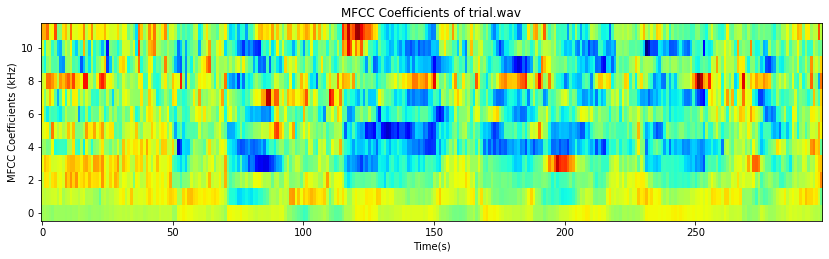

In [12]:
cep_lifter = 23
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift

fig = plt.figure(figsize=(14, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(mfcc.T, cmap="jet",aspect='auto', origin='lower')
ax2.set_title('MFCC Coefficients of ' + filename)
ax2.set_ylabel('MFCC Coefficients (kHz)')
ax2.set_xlabel('Time(s)')

## 7.平均归一化 
为了平衡频谱并提高信噪比，可以简单的减去每一帧系数的平均值

Text(0.5, 0, 'Time(s)')

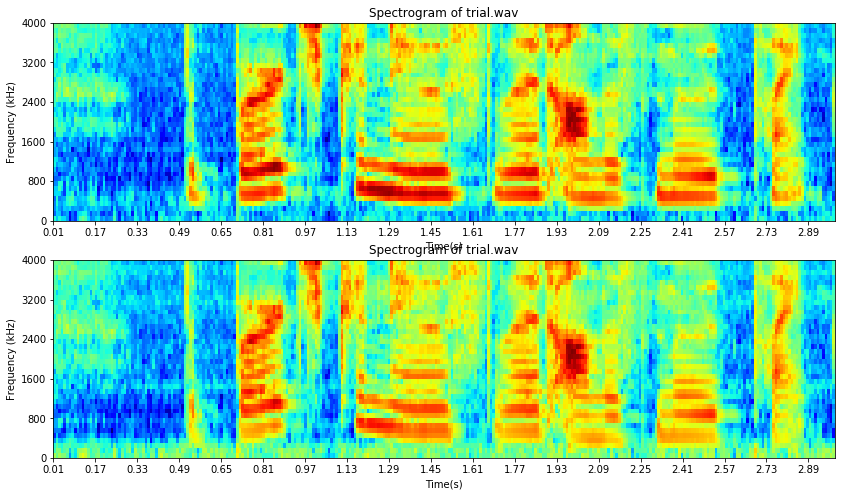

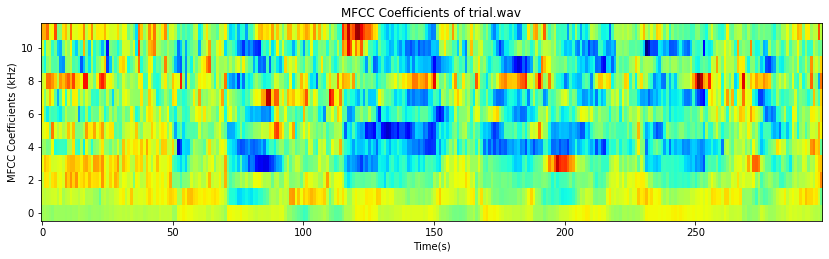

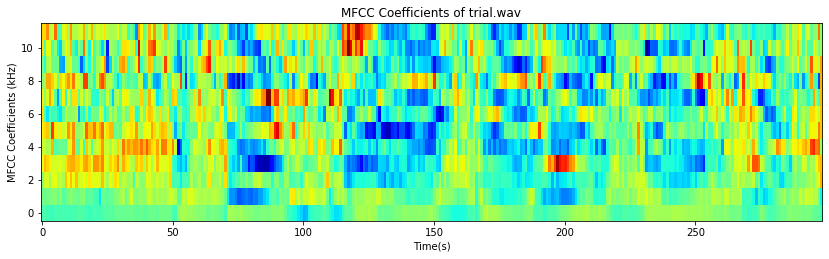

In [16]:
filter_banks = filter_bank_signal - np.mean(filter_bank_signal, axis=0) + 1e-8

fig = plt.figure(figsize=(14, 8))

ax2 = fig.add_subplot(211)
ax2.imshow(filter_bank_signal.T, cmap="jet",aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequency (kHz)')
ax2.set_xlabel('Time(s)')

ax2 = fig.add_subplot(212)
ax2.imshow(filter_banks.T, cmap="jet",aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequency (kHz)')
ax2.set_xlabel('Time(s)')

mfcc_norm = mfcc - np.mean(mfcc, axis=0) + 1e-8

fig = plt.figure(figsize=(14, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(mfcc.T, cmap="jet",aspect='auto', origin='lower')
ax2.set_title('MFCC Coefficients of ' + filename)
ax2.set_ylabel('MFCC Coefficients (kHz)')
ax2.set_xlabel('Time(s)')
fig = plt.figure(figsize=(14, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(mfcc_norm.T, cmap="jet",aspect='auto', origin='lower')
ax2.set_title('MFCC Coefficients of ' + filename)
ax2.set_ylabel('MFCC Coefficients (kHz)')
ax2.set_xlabel('Time(s)')

如果所使用的算法对于输入特征的相关性没有严格的要求的化，使用filter-bank是比较建议的，相反使用MFCC。